# Validation
### Checking the relevance of Feature Engineering and correlation to remove unecessary variables and improve the accuracy

The aim is to create a model to predict next headway with:
* all variables
* selected variables

In [1]:
import pandas as pd
#import pandas_profiling
import numpy as np
import os
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from matplotlib import pyplot as plt
import time

In [2]:
# Choose the city of analysis

city = 'Recife'
# city = 'CG'
# city = 'Curitiba'

In [3]:
path = os.getcwd() + "/../data/output/" + city + "/"

# All variables
all_data = "new_feats_data.csv"
integrated_data_path = path + all_data

In [4]:
# Reading data

df_all_data = pd.read_csv(integrated_data_path)

In [5]:
df_selected_data = pd.read_csv(integrated_data_path)

In [6]:
rows_number = 1000000 #len(df_all_data) #100000

In [7]:
df_all_data = df_all_data.loc[0:rows_number]
df_selected_data = df_selected_data.loc[0:rows_number]

### Converting NaN values

Changing NaN by median or:
- values of shape for gps

In [ ]:
df_all_data.isnull().any()

In [8]:
# changing by shape data
df_all_data.gpsPointId = np.where(df_all_data.gpsPointId.isnull(), 0, df_all_data.gpsPointId)
df_all_data.gpsLat = np.where(df_all_data.gpsLat.isnull(), df_all_data.shapeLat, df_all_data.gpsLat)
df_all_data.gpsLon = np.where(df_all_data.gpsLon.isnull(), df_all_data.shapeLon, df_all_data.gpsLon)
df_all_data.distanceToShapePoint = np.where(df_all_data.distanceToShapePoint.isnull(), 
                                            0, df_all_data.distanceToShapePoint)


In [9]:
#grouping by weekday and filling NA's with the median of the column
numeric_feats = df_all_data.dtypes[(df_all_data.dtypes != "object") & (df_all_data.dtypes != "datetime64[ns]")
                               & (df_all_data.dtypes != "bool")].index
df_all_data[numeric_feats] = df_all_data.groupby(['WEEKDAY(gps_datetime)'])[numeric_feats].transform(lambda x: x.fillna(x.median()))

df_all_data.head(5)

,route,tripNum,shapeId,routeFrequency,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,...,YEAR(alertDateTime),YEAR(jamUpdateDateTime),MONTH(gps_datetime),MONTH(precipitationTime),MONTH(alertDateTime),MONTH(jamUpdateDateTime),WEEKDAY(gps_datetime),WEEKDAY(precipitationTime),WEEKDAY(alertDateTime),WEEKDAY(jamUpdateDateTime)
0,96,1,Route_219,low_frequency,22857,-8.046589,-34.878125,3606.0,50661,0.0,...,2018.0,2018.0,12,12,12.0,12.0,2,2,2.0,2.0
1,96,1,Route_219,low_frequency,22857,-8.046589,-34.878125,3606.0,50671,409090.0,...,2018.0,2018.0,12,12,12.0,12.0,2,2,2.0,2.0
2,96,1,Route_219,low_frequency,22857,-8.046589,-34.878125,3606.0,50669,406112.0,...,2018.0,2018.0,12,12,12.0,12.0,2,2,2.0,2.0
3,96,1,Route_219,low_frequency,22857,-8.046589,-34.878125,3606.0,50662,0.0,...,2018.0,2018.0,12,12,12.0,12.0,2,2,2.0,2.0
4,96,1,Route_219,low_frequency,22857,-8.046589,-34.878125,3606.0,50663,0.0,...,2018.0,2018.0,12,12,12.0,12.0,2,2,2.0,2.0


In [ ]:
df_all_data.isnull().any()

In [ ]:
df_all_data.dtypes

In [10]:
# Converting bool to float
df_all_data.alertIsJamUnifiedAlert = df_all_data.alertIsJamUnifiedAlert.astype(np.float64)
df_all_data.alertInScale = df_all_data.alertInScale.astype(np.float64)
df_all_data.busBunching = df_all_data.busBunching.astype(np.float64)

### Converting categorical variables

In [11]:
df_all_data = pd.get_dummies(df_all_data)
df_all_data.head()

,route,tripNum,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,gpsLon,...,alertType_-,alertType_ACCIDENT,alertType_CHIT_CHAT,alertType_HAZARD,alertType_JAM,alertType_POLICE,alertType_ROAD_CLOSED,jamBlockType_-,jamBlockType_ROAD_CLOSED_CONSTRUCTION,jamBlockType_ROAD_CLOSED_EVENT
0,96,1,22857,-8.046589,-34.878125,3606.0,50661,0.0,-8.046589,-34.878125,...,0,0,0,1,0,0,0,1,0,0
1,96,1,22857,-8.046589,-34.878125,3606.0,50671,409090.0,-8.046559,-34.878171,...,0,0,0,1,0,0,0,1,0,0
2,96,1,22857,-8.046589,-34.878125,3606.0,50669,406112.0,-8.046468,-34.878234,...,0,0,0,1,0,0,0,1,0,0
3,96,1,22857,-8.046589,-34.878125,3606.0,50662,0.0,-8.046589,-34.878125,...,0,0,0,1,0,0,0,1,0,0
4,96,1,22857,-8.046589,-34.878125,3606.0,50663,0.0,-8.046589,-34.878125,...,0,0,0,1,0,0,0,1,0,0


In [ ]:
# Descriptive statistics
profile = pandas_profiling.ProfileReport(df_all_data, check_correlation=True, correlation_threshold=0.5)

In [ ]:
profile.to_file(outputfile=path + "output_after_fe_profile.html")

## Model with all variables

For headway prediction

In [ ]:
# y = df_all_data.drop('busBunching', axis=1) # with classifier produce error: asking to convert to float (doesn't make sense, it's a class)
y = df_all_data['headway']
df_all_data.drop('headway', axis=1, inplace=True)

X = df_all_data

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, test_size=0.5)

headway_busBunching_test = X_test_all[['headwayThreshold', 'busBunching']]
X_test_all.drop('busBunching', axis=1, inplace=True)
X_train_all.drop('busBunching', axis=1, inplace=True)

For bus bunching prediction

In [12]:
y = df_all_data['busBunching']
df_all_data.drop('busBunching', axis=1, inplace=True)
#df_all_data.drop('headway', axis=1, inplace=True)

X = df_all_data

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, test_size=0.5)

#### Modelo RF (Random Forest)
Random Forest é um algoritmo que ajusta várias árvores de decisão de classificação em várias subamostras do conjunto de dados e usa a média para melhorar a precisão preditiva e controlar o ajuste excessivo. A quantidade de árvores (n_estimators) é um parâmetro, cujo valor, deve ser encontrado, para que o modelo melhor represente os dados.

In [13]:
# function to train the model and to calculate the RMSE with cross validation
def rmse_cv(model, X_train, y_train):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring = "neg_mean_squared_error", cv = 10))
    return(rmse)

# function to print the coefficients of the model
def print_coefficients(model):
    w = list(model.coef_)
    # Parameters must be in reverse order because the poly function 
    w.reverse()
    print (np.poly1d(w) + model.intercept_)

# function to train the model and to return the score
def train_model(model, X_train, y_train, X_test, y_test, print_coef):
    start_time = time.time()

    model.fit(X_train, y_train)
#     if (print_coef):
#         print_coefficients(model)
    
    score = model.score(X_test, y_test) #how well our model is
    y_predict = model.predict(X_test)
    execution_time = time.time() - start_time
    return score, execution_time, y_predict

# function to plot the RMSE vs parameter value
def plot_rmse_param(series, param_name):
    series.plot(title = "Validation Error vs " + param_name)
    plt.xlabel(param_name)
    plt.ylabel("RMSE")
    
# function to get the best RMSE and the best parameter value of the model
def best_rmse_param(series):
    best_rmse = series.min()
    best_param = series.idxmin() 
    
    return(best_rmse, best_param)

def get_accuracy(y_predicted, y_real, label):
    
    if label == "headway":
        y_real['predictedBusBunching'] = y_real['headwayThreshold'].ge(y_predicted, axis=0).astype(np.float64)
        accuracy = accuracy_score(y_real['busBunching'], y_real['predictedBusBunching']) #y_true, y_pred
    else:
        accuracy = accuracy_score(y_real, y_predicted) #y_true, y_pred
    
    return accuracy

def get_fmeasure(y_predicted, y_real, label):
    
    if label == "headway":
        y_real['predictedBusBunching'] = y_real['headwayThreshold'].ge(y_predicted, axis=0).astype(np.float64)
        fmeasure = f1_score(y_real['busBunching'], y_real['predictedBusBunching']) #y_true, y_pred
    else:
        fmeasure = f1_score(y_real, y_predicted) #y_true, y_pred
                                              
    return fmeasure

def get_precision(y_predicted, y_real, label):
    
    if label == "headway":
        y_real['predictedBusBunching'] = y_real['headwayThreshold'].ge(y_predicted, axis=0).astype(np.float64)
        precision = precision_score(y_real['busBunching'], y_real['predictedBusBunching']) #y_true, y_pred
    else:
        precision = precision_score(y_real, y_predicted) #y_true, y_pred
                                              
    return precision

def get_recall(y_predicted, y_real, label):
    
    if label == "headway":
        y_real['predictedBusBunching'] = y_real['headwayThreshold'].ge(y_predicted, axis=0).astype(np.float64)
        recall = recall_score(y_real['busBunching'], y_real['predictedBusBunching']) #y_true, y_pred
    else:
        recall = recall_score(y_real, y_predicted) #y_true, y_pred
                                              
    return recall

In [ ]:
n_estimators = [1, 10, 50, 100]
cv_rf_rmse = [rmse_cv(RandomForestRegressor(n_estimators = n, n_jobs=8), X_train_all, y_train_all).mean() 
            for n in n_estimators]

series = pd.Series(cv_rf_rmse, index = n_estimators)
plot_rmse_param(series, "n_estimators")

In [ ]:
best_rmse_rf, best_estimator_rf_all = best_rmse_param(series)

In [ ]:
n_min_samples_split = [2,3,4,5,6,7,8,9,10]
cv_rf_rmse = [rmse_cv(RandomForestRegressor(n_estimators = best_estimator_rf_all, min_samples_split = n, n_jobs=8), X_train_all, y_train_all).mean() 
            for n in n_min_samples_split]

series = pd.Series(cv_rf_rmse, index = n_min_samples_split)
plot_rmse_param(series, "n_min_samples_split")

In [ ]:
best_rmse_rf, best_split_rf = best_rmse_param(series)

In [ ]:
# best_rmse_rf, best_param_rf = best_rmse_param(series)

model_rf = RandomForestRegressor(n_estimators = best_estimator_rf_all, min_samples_split = best_split_rf, n_jobs=8)
score_rf_all, exec_time_all, y_predict_all = train_model(model_rf, X_train_all, y_train_all, X_test_all, y_test_all, 
                                      False)

In [ ]:
accuracy_rf_all = get_accuracy(y_predict_all, headway_busBunching_test, "headway")
precision_rf_all = get_precision(y_predict_all, headway_busBunching_test, "headway")
recall_rf_all = get_recall(y_predict_all, headway_busBunching_test, "headway")
fmeasure_rf_all = get_fmeasure(y_predict_all, headway_busBunching_test, "headway")

In [ ]:
# del variables

del df_all_data
del cv_rf_rmse
del series
del model_rf
del y
del X
del X_train_all
del X_test_all
del y_train_all
del y_test_all

#### Support Vector Regressor Model

In [ ]:
# Support Vector Regressor Model - it takes to long to execute

# cs = [0.01, 1, 5, 10, 25, 50]
# cv_svr_rmse = [rmse_cv(SVR(C = c), X_train_all, y_train_all).mean() 
#             for c in cs]

# series_svr = pd.Series(cv_svr_rmse, index = cs)
# plot_rmse_param(series_svr, "C")

In [ ]:
# best_rmse_svr_all, best_param_svr_all = best_rmse_param(series_svr)

# model_svr_all = SVR(C = best_rmse_svr_all)
# score_svr_all, exec_time_svr_all = train_model(model_svr_all, False)

#### Logistic Regression Model

c:\python27\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\python27\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
c:\python27\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


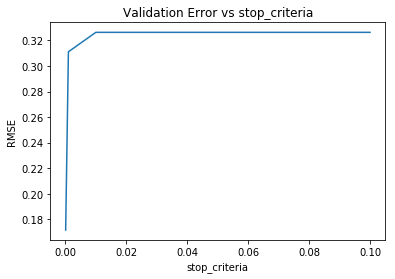

In [14]:
stop_criteria = [0.1, 0.01, 0.001, 0.0001]
cv_lr_rmse = [rmse_cv(LogisticRegression(tol = t, n_jobs=8), X_train_all, y_train_all).mean() 
            for t in stop_criteria]

series = pd.Series(cv_lr_rmse, index = stop_criteria)
plot_rmse_param(series, "stop_criteria")

In [15]:
best_rmse_lr_all, best_stop_lr_all = best_rmse_param(series)

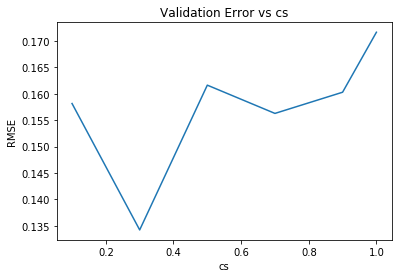

In [16]:
cs = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
cv_lr_rmse = [rmse_cv(LogisticRegression(tol = best_stop_lr_all, C = c, n_jobs=8), X_train_all, y_train_all).mean() 
            for c in cs]

series = pd.Series(cv_lr_rmse, index = cs)
plot_rmse_param(series, "cs")

In [17]:
best_rmse_lr_all, best_c_lr_all = best_rmse_param(series)

In [18]:
model_lr = LogisticRegression(tol = best_stop_lr_all, C = best_c_lr_all, n_jobs=8)
score_lr_all, exec_time_lr_all, y_predict_lr_all = train_model(model_lr, X_train_all, y_train_all, X_test_all, y_test_all, 
                                      False)

In [19]:
accuracy_lr_all = get_accuracy(y_predict_lr_all, y_test_all, "busBunching")
precision_lr_all = get_precision(y_predict_lr_all, y_test_all, "busBunching")
recall_lr_all = get_recall(y_predict_lr_all, y_test_all, "busBunching")
fmeasure_lr_all = get_fmeasure(y_predict_lr_all, y_test_all, "busBunching")

Usar regressão (reduzir dimensionalidade) -> é linear (RF foi aleatório) ou outros modelos

## Model with less (13) variables

- Todas as variáveis de dia, mês e ano - data do gps é suficiente
- alertInScale - alertIsJamUnifiedAlert é suficiente
- alertLat e alertLon - localização do gps é suficiente
- alertNThumbsUp e alertReliability - alertConfidence é suficiente
- jamDelay e jamLenght - jamSeverity é suficiente

In [20]:
df_selected_data.drop(['DAY(alertDateTime)', 'DAY(jamUpdateDateTime)', 'MONTH(alertDateTime)', 
                        'MONTH(jamUpdateDateTime)', 'YEAR(alertDateTime)', 'YEAR(jamUpdateDateTime)',
                       'alertInScale', 'alertLatitude', 'alertLongitude', 'alertNThumbsUp',
                       'alertReliability', 'jamDelay', 'jamLength'], axis=1, inplace=True)

Test with 50% of the variables.

In [ ]:
#df_selected_data.drop(['route', 'tripNum', 'distanceTraveledShape', 'gpsPointId', 'gpsLat', 'gpsLon', 
#                       'distanceToShapePoint', 'problem', 'alertType', 'alertRoadType', 'alertNComments', 
#                       'alertNImages', 'alertNThumbsUp', 'alertReliability', 'alertReportMood', 'alertReportRating', 
#                       'alertSpeed', 'alertLatitude', 'alertLongitude', 'alertIsJamUnifiedAlert', 'alertInScale', 
#                       'jamBlockType', 'jamSpeedKM'], axis=1, inplace=True)

In [ ]:
df_selected_data.head()

Test with 25% of the variables.

In [ ]:
# df_selected_data.drop(['route','tripNum','shapeId','shapeSequence','distanceTraveledShape','gpsPointId','gpsLat',
#                        'gpsLon','distanceToShapePoint','gps_datetime','stopPointId','problem','precipitationTime',
#                        'alertDateTime','alertType','alertRoadType','alertNComments','alertNImages','alertNThumbsUp',
#                        'alertReliability','alertReportMood','alertReportRating','alertSpeed','alertLatitude',
#                        'alertLongitude','alertDistanceToClosestShapePoint','alertIsJamUnifiedAlert','alertInScale',
#                        'jamUpdateDateTime','jamExpirationDateTime','jamBlockType','jamDelay','jamLength','jamLevel',
#                        'jamSpeedKM','jamDistanceToClosestShapePoint','headwayThreshold'], axis=1, inplace=True)

In [ ]:
df_selected_data

In [21]:
# changing by shape data

df_selected_data.gpsPointId = np.where(df_selected_data.gpsPointId.isnull(), 0, 
                                       df_selected_data.gpsPointId)
df_selected_data.gpsLat = np.where(df_selected_data.gpsLat.isnull(), df_selected_data.shapeLat,
                                   df_selected_data.gpsLat)
df_selected_data.gpsLon = np.where(df_selected_data.gpsLon.isnull(), df_selected_data.shapeLon, 
                                   df_selected_data.gpsLon)
df_selected_data.distanceToShapePoint = np.where(df_selected_data.distanceToShapePoint.isnull(), 
                                            0, df_selected_data.distanceToShapePoint)


In [22]:
#grouping by weekday and filling NA's with the median of the column
numeric_feats = df_selected_data.dtypes[(df_selected_data.dtypes != "object") & 
                                        (df_selected_data.dtypes != "datetime64[ns]")
                               & (df_selected_data.dtypes != "bool")].index
df_selected_data[numeric_feats] = df_selected_data.groupby(['WEEKDAY(gps_datetime)'])[numeric_feats].transform(lambda x: x.fillna(x.median()))

In [23]:
# Converting bool to float
df_selected_data.alertIsJamUnifiedAlert = df_selected_data.alertIsJamUnifiedAlert.astype(np.float64)
df_selected_data.busBunching = df_selected_data.busBunching.astype(np.float64)

In [24]:
# Converting categorical variable

df_selected_data = pd.get_dummies(df_selected_data)

For headway prediction

In [ ]:
# y = df_all_data.drop('busBunching', axis=1) # with classifier produce error
y_sel = df_selected_data['headway']
df_selected_data.drop('headway', axis=1, inplace=True)

X_sel = df_selected_data

X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_sel, y_sel, test_size=0.5)

headway_busBunching_test_sel = X_test_sel[['headwayThreshold', 'busBunching']]
X_test_sel.drop('busBunching', axis=1, inplace=True)
X_train_sel.drop('busBunching', axis=1, inplace=True)

For bus bunching prediction

In [25]:
y_sel = df_selected_data['busBunching']
df_selected_data.drop('busBunching', axis=1, inplace=True)
#df_all_data.drop('headway', axis=1, inplace=True)

X_sel = df_selected_data

X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_sel, y_sel, test_size=0.5)

Random Forest Model

In [ ]:
# best_rmse_rf_sel, best_param_rf_sel = best_rmse_param(series)

model_rf_sel = RandomForestRegressor(n_estimators = best_estimator_rf_all,  min_samples_split = best_split_rf, n_jobs=8)
score_rf_sel, exec_time_sel, y_predict_sel = train_model(model_rf_sel, X_train_sel, y_train_sel, X_test_sel, y_test_sel, False)

In [ ]:
accuracy_rf_sel = get_accuracy(y_predict_sel, headway_busBunching_test_sel)
precision_rf_sel = get_precision(y_predict_sel, headway_busBunching_test_sel)
recall_rf_sel = get_recall(y_predict_sel, headway_busBunching_test_sel)
fmeasure_rf_sel = get_fmeasure(y_predict_sel, headway_busBunching_test_sel)

In [ ]:
# cs = [0.01, 1, 5, 10, 25, 50]
# cv_svr_rmse = [rmse_cv(SVR(C = c), X_train_sel, y_train_sel).mean() 
#             for c in cs]

# series_svr = pd.Series(cv_svr_rmse, index = cs)
# plot_rmse_param(series_svr, "C")

In [ ]:
# best_rmse_svr_sel, best_param_svr_sel = best_rmse_param(series_svr)

# model_svr_sel = SVR(C = best_param_svr_sel)
# score_svr_sel, exec_time_sel_svr = train_model(model_svr_sel, False)

#### Logistic Regression Model

In [26]:
model_lr_sel = LogisticRegression(tol = best_stop_lr_all, C = best_c_lr_all, n_jobs=8)
score_lr_sel, exec_time_lr_sel, y_predict_lr_sel = train_model(model_lr_sel, X_train_sel, y_train_sel,
                                                               X_test_sel, y_test_sel, False)

In [27]:
accuracy_lr_sel = get_accuracy(y_predict_lr_sel, y_test_sel, "busBunching")
precision_lr_sel = get_precision(y_predict_lr_sel, y_test_sel, "busBunching")
recall_lr_sel = get_recall(y_predict_lr_sel, y_test_sel, "busBunching")
fmeasure_lr_sel = get_fmeasure(y_predict_lr_sel, y_test_sel, "busBunching")

## Results

Execution just with Random Forest because is more efficient with good accuracy.

In [ ]:
print("Data: %s rows" % rows_number)
print("Random Forest Model - All Variables: \nEstimators = %s \nN_Split = %s \nAccuracy = %s \nPrecision = %s \nRecall = %s \nF-Measure = %s \nR2 = %s \nExecution time = %s \n" % 
      (best_estimator_rf_all, best_split_rf, accuracy_rf_all, precision_rf_all, recall_rf_all, fmeasure_rf_all, score_rf_all, exec_time_all))
print("Random Forest Model - Less Variables: \nEstimators = %s \nN_Split = %s \nAccuracy = %s \nPrecision = %s \nRecall = %s \nF-Measure = %s \nR2 = %s \nExecution time = %s \n" % 
      (best_estimator_rf_all, best_split_rf, accuracy_rf_sel, precision_rf_sel, recall_rf_sel, fmeasure_rf_sel, score_rf_sel, exec_time_sel))

# print("SVR Model - All Variables: \nEstimators = %s \nRMSE = %s \nR2 = %s \nExecution time = %s \n" % 
#       (best_param_svr, best_rmse_svr, score_svr, exec_time_svr_all))
# print("SVR Model - Less Variables: \nEstimators = %s \nRMSE = %s \nR2 = %s \nExecution time = %s \n" % 
#       (best_param_svr_sel, best_rmse_svr_sel, score_svr_sel, exec_time_svr_sel))


In [28]:
def plot_results(df_results, name):
    fig, ax = plt.subplots(figsize=(7,5))
    results_plot = df_results.plot.bar(x = "Input", logy=True, grid=True, colormap="tab20b", ax=ax, rot=0)
    plt.xlabel("")
    
    results_plot.get_figure().savefig(path + name)

Random Forest

In [ ]:
labels = ["Input","Accuracy","Precision","Recall","F-Measure","R2","Execution Time (Min)"]
results = []
results.append(["RF - All variables", accuracy_rf_all, precision_rf_all, recall_rf_all, fmeasure_rf_all, score_rf_all, (exec_time_all/60)])
results.append(["RF - Selected variables", accuracy_rf_sel, precision_rf_sel, recall_rf_sel, fmeasure_rf_sel, score_rf_sel, (exec_time_sel/60)])

df_results = pd.DataFrame.from_records(results, columns=labels)
print(df_results)

plot_results(df_results, "results_comparison_rf.png")

In [ ]:
df_results

Logistic Regression

                     Input  Accuracy  Precision    Recall  F-Measure  \
0       LR - All variables  0.979586   0.928231  0.876571   0.901662   
1  LR - Selected variables  0.973284   0.922212  0.818834   0.867454   

         R2  Execution Time (Min)  
0  0.979586              3.651583  
1  0.973284              7.136333  


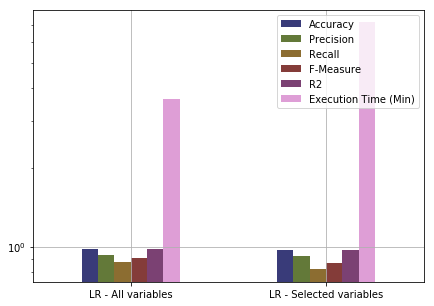

In [29]:
labels = ["Input","Accuracy","Precision","Recall","F-Measure","R2","Execution Time (Min)"]
results = []
results.append(["LR - All variables", accuracy_lr_all, precision_lr_all, recall_lr_all, fmeasure_lr_all, score_lr_all, (exec_time_lr_all/60)])
results.append(["LR - Selected variables", accuracy_lr_sel, precision_lr_sel, recall_lr_sel, fmeasure_lr_sel, score_lr_sel, (exec_time_lr_sel/60)])

df_results_lr = pd.DataFrame.from_records(results, columns=labels)
print(df_results_lr)

plot_results(df_results_lr, "results_comparison_lr_1000000.png")

In [30]:
df_results_lr

,Input,Accuracy,Precision,Recall,F-Measure,R2,Execution Time (Min)
0,LR - All variables,0.979586,0.928231,0.876571,0.901662,0.979586,3.651583
1,LR - Selected variables,0.973284,0.922212,0.818834,0.867454,0.973284,7.136333
